<img src="images/econ140R_logo.png" width="200" />

In the following cell, please type your name and SID:

In the cell below, please write out the [Honor Code](https://teaching.berkeley.edu/berkeley-honor-code) to reaffirm you are abiding by it.

Did you work with other students? List them below. Please write your answers in your own words, not in theirs.

<h1>ECON 140R - Problem Set 3 Part 1</h1>

<font color="red"><b>Please complete Problem Set 3 Part 2 also</b></font>

<h2>INSTRUCTIONS</h2>

Please step through this problem set, copying and pasting code as needed, and run the code to produce output. Answer the questions asked, which appear in <font color="blue">blue font</font>. You will earn 100% of the credit on this problem set for <b>completing</b> it with working code and coherent answers. Answers do not need to be correct for full credit.

Throughout, <b>you may consult outside sources like the paper below or other commentary</b>, but your analysis should be in your own words. We will not run TurnItIn software on this Problem Set, but as usual, you should not borrow phrases without attribution or commit "mosaic plagiarism."

In this problem set we're examining a special extract of the 1980 Census to replicate [Angrist and Krueger (1994)](https://www-jstor-org.libproxy.berkeley.edu/stable/2535121), who research "Why Do World War II Veterans Earn More than Nonveterans?" We will use ordinary least squares and two-stage least squares (2SLS), a common implementation of instrumental variables, to replicate their primary results shown in their Table 4, which is reprinted below:

<img src="images/angrist-krueger-1994-ta4.png" width="500" />

In [2]:
library(tidyverse)
library(haven)
library(ggplot2)
install.packages("ivreg", dependencies = TRUE)
library("ivreg")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Installing package into ‘/opt/r’
(as ‘lib’ is unspecified)



It turns out that this handy command stops __R__ from defaulting to scientific notation. 

In [3]:
options(scipen=999)

<hr>

Below, we load in a 50% randomly selected subsample of an extract downloaded from IPUMS of the 1980 Census public-use microsample, which is a 5% flat cut of the entire Census. (So we are looking at a 2.5% flat cut.) This particular extract contains men only, who were born in 1925, 1926, 1927, and 1928. The data also contain their quarter of birth, whether they served in WWII `wwii`, and their wage and salary income `incwage`, and several other characteristics.

The 1980 Census was unique in asking about month of birth on the [short form](https://www.census.gov/history/pdf/1980_short_questionnaire.pdf), which everyone answered. The public-use microdata sample condensed this into quarter of birth, but `birthqtr` is still fairly unique across Census products. Some other datasets measure month of birth, and restricted-use datasets may also supply even day of birth.

You can download these data yourself. But be advised the the full dataset contains over 11 million records, or 5% of the nation's roughly 227 million people in 1980. Even with just 36 variables selected, the extract is over a gigabyte in size and is too large for datahub.

<hr>

Let's load up and look at the data.

In [4]:
data_c80_regsample = read_dta("data_c80_regsample_3.dta")
head(data_c80_regsample)

year,sample,serial,hhwt,cluster,statefip,metro,strata,gq,pernum,⋯,b27q4,b28q2,b28q3,b28q4,srgrp,b25q1,b26q1,b27q1,b28q1,regsample
<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl+lbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1980,198001,9057,20,1980000090571,1,0,27,1,1,⋯,0,1,0,0,NA,0,0,0,0,1
1980,198001,9181,20,1980000091811,1,0,24,1,1,⋯,0,0,0,0,NA,0,0,0,0,1
1980,198001,9292,20,1980000092921,1,0,6,1,1,⋯,1,0,0,0,NA,0,0,0,0,1
1980,198001,9329,20,1980000093291,1,0,24,1,1,⋯,0,0,0,0,2,0,0,0,0,1
1980,198001,9403,20,1980000094031,1,0,6,1,1,⋯,0,0,0,0,NA,0,1,0,0,1
1980,198001,9417,20,1980000094171,1,0,24,1,1,⋯,0,0,0,0,NA,0,0,0,1,1


Here is a baseline regression of a useful $Y$ variable, log pre-tax wage and salary income, which is [described at IPUMS here](https://usa.ipums.org/usa-action/variables/INCWAGE#description_section):

$$
\ln Y_i = \alpha + \beta^{w} \ wwii_i + B \ controls_i + \epsilon_i
$$

where we are controlling for 0/1 WWII service; year of birth; being white (Black, Hispanic, and other men are the baseline omitted category); being married in 1980; a 0/1 indicator of living and working in a standard metropolitan statistical area (SMSA); years of education; a 0/1 indicator of a disability that limits or prevents work; and 49 indicators for 48 lower states (AK and HI are dropped) plus DC.

We'll run this regression and examine what we find for $\beta^w$. Let's follow what [Angrist and Krueger (1994)](https://www-jstor-org.libproxy.berkeley.edu/stable/2535121) do in the left side of Table 4, marked "OLS," which looks a lot like the left-hand side of Table 2.2 in <i>Mastering Metrics</i> Chapter 2. In both, the authors start with a simple model and the add some covariates that might have (and did) inject omitted variable bias. Here's what we'll do:

1. $\ln Y_i = \alpha + \beta^{w} \ wwii_i + \sum \beta^{by} \ birthyear_i  + \epsilon_i$

2. $\ln Y_i = \alpha + \beta^{w} \ wwii_i + \sum \beta^{by} \ birthyear_i  + \beta^wnh \ white_i + \beta^m \ married_i + \sum \beta^{s}\ state_i + \beta^u \ SMSA_i + \epsilon_i$

2. $\ln Y_i = \alpha + \beta^{w} \ wwii_i + \sum \beta^{by} \ birthyear_i  + \beta^wnh \ white_i + \beta^m \ married_i + \sum \beta^{s}\ state_i + \beta^u \ SMSA_i + \beta^e \ educ_i + \beta^d \ disability_i + \epsilon_i$

<h4>
<font color="blue">Complete the code below and run it.</font>
    </h4>

In [5]:
c80_reg1 <- lm(logincwage ~ wwii + factor(birthyr), 
               data = data_c80_regsample)
summary(c80_reg1)


Call:
lm(formula = logincwage ~ wwii + factor(birthyr), data = data_c80_regsample)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.8953 -0.2852  0.0974  0.4115  1.7050 

Coefficients:
                    Estimate Std. Error  t value             Pr(>|t|)    
(Intercept)         9.520292   0.006679 1425.342 < 0.0000000000000002 ***
wwii                0.238044   0.005669   41.990 < 0.0000000000000002 ***
factor(birthyr)1926 0.030991   0.007277    4.259      0.0000205986402 ***
factor(birthyr)1927 0.047956   0.007225    6.637      0.0000000000322 ***
factor(birthyr)1928 0.144340   0.007668   18.824 < 0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7295 on 81506 degrees of freedom
Multiple R-squared:  0.02156,	Adjusted R-squared:  0.02151 
F-statistic: 448.9 on 4 and 81506 DF,  p-value: < 0.00000000000000022


<font color="blue">
    <h3>
    Question 1</h3>
    Look at the regression output above and describe what you see. How much more do male veterans of WWII earn compared to male nonveterans? Is the effect statistically significant? Describe using the reported numbers in the regression output, and also state what you see in descriptive sentences where you refer to the percentages revealed by the reported numbers. 
</font>

In this sparse model, we see a very large earnings benefit for WWII veterans, about 24%. This is larger than what is shown in the far left-hand column in Table 4 in Angrist and Krueger (1994), probably because our sample is slightly different. The earnings benefit is statistically significant.

<h4>
<font color="blue">Complete the code below and run it.</font>
    </h4>

In [6]:
c80_reg2 <- lm(logincwage ~ wwii + factor(birthyr) + white + married 
               + factor(statefip) + smsa, 
               data = data_c80_regsample)
summary(c80_reg2)


Call:
lm(formula = logincwage ~ wwii + factor(birthyr) + white + married + 
    factor(statefip) + smsa, data = data_c80_regsample)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7758 -0.2721  0.0787  0.3938  2.3530 

Coefficients:
                     Estimate Std. Error t value             Pr(>|t|)    
(Intercept)          8.641358   0.021726 397.736 < 0.0000000000000002 ***
wwii                 0.155759   0.005508  28.280 < 0.0000000000000002 ***
factor(birthyr)1926  0.028452   0.006935   4.103 0.000040860331962350 ***
factor(birthyr)1927  0.045273   0.006886   6.575 0.000000000048917862 ***
factor(birthyr)1928  0.109530   0.007322  14.959 < 0.0000000000000002 ***
white                0.360574   0.008828  40.847 < 0.0000000000000002 ***
married              0.365901   0.007132  51.301 < 0.0000000000000002 ***
factor(statefip)4    0.046048   0.030576   1.506             0.132062    
factor(statefip)5   -0.070275   0.031918  -2.202             0.027686 *  
factor(statefip)6 

<font color="blue">
    <h3>
    Question 2</h3>
    Look at the regression output above and describe what you see. How much more do male veterans of WWII earn compared to male nonveterans? Is the effect statistically significant? Discuss what is different about this regression compared to the first one above, in terms of the controls. Are these bad controls? California is <i>statefip</i> == 6; how does California residence affect earnings? State what you see in descriptive sentences.
</font>

In this regression, we are including more controls, and we see the earnings benefit fall, from 24% in the first regression to roughly 16% here, which is very close to what we see in AK Table 4 column 2. The effect is still strongly significant. We have controlled for state of residence, SMSA (urban) residence, being white, and being married. The two latter characteristics are usually associated with higher earnings, and we see that confirmed here. 

One would expect both white identity and marital status might be positively correlated with WWII veteran status, and in the data they are. Race is determined before military service, so controlling for it here seems like the right move. For some of the other controls, it might seem less obvious whether they might close off channels of causality running from WWII veteran status to earnings, in which case they are bad controls, or if they mostly explain earnings but might be correlated with WWII veteran status, in which case they are good controls. Angrist and Krueger seem to think they are good controls.

California residence raises earnings. Several other states have higher earnings associated with them too, and SMSA (urban) residene also does.

<h4>
<font color="blue">Complete the code below and run it.</font>
    </h4>

In [7]:
c80_reg3 <- lm(logincwage ~ wwii + factor(birthyr) + white + married 
               + factor(statefip) + smsa 
               + edyrs + disability, 
               data = data_c80_regsample)
summary(c80_reg3)


Call:
lm(formula = logincwage ~ wwii + factor(birthyr) + white + married + 
    factor(statefip) + smsa + edyrs + disability, data = data_c80_regsample)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.8939 -0.2440  0.0803  0.3710  2.7084 

Coefficients:
                      Estimate Std. Error t value             Pr(>|t|)    
(Intercept)          8.2333178  0.0211386 389.492 < 0.0000000000000002 ***
wwii                 0.0822755  0.0052242  15.749 < 0.0000000000000002 ***
factor(birthyr)1926  0.0208069  0.0065043   3.199             0.001380 ** 
factor(birthyr)1927  0.0245310  0.0064607   3.797             0.000147 ***
factor(birthyr)1928  0.0556310  0.0068854   8.080 0.000000000000000659 ***
white                0.2481302  0.0083690  29.649 < 0.0000000000000002 ***
married              0.3364927  0.0066966  50.248 < 0.0000000000000002 ***
factor(statefip)4    0.0063917  0.0286789   0.223             0.823637    
factor(statefip)5   -0.0702609  0.0299315  -2.347             

<font color="blue">
    <h3>
    Question 3</h3>
   Look at the regression output above and describe what you see. How much more do male veterans of WWII earn compared to male nonveterans? Is the effect statistically significant? Discuss what is different about this regression compared to the second one above, in terms of the controls. Are these bad controls? California is statefip == 6; how does California residence affect earnings? State what you see in descriptive sentences.
</font>

Here we have added years of education and work disability status to the list of controls, and that pushes the earnings benefit for WWII veterans down to about 8%, still statistically significant.

It is much cloudier whether education and disability might be channels of causality through which WWII veteran status affects earnings. What we are looking for in answers to a murky question like this is evidence of your ability to think through the issues and write about them briefly. Angrist and Krueger write about this themselves, starting on the bottom of page 82. They write that it is useful to look at estimates that do and do not control for education, because military service may well affect earnings through education. In this study, when quarter of birth ultimately matters a lot for disentangling things, they are also concerned with how quarter of birth may independently affect earnings through its effect on educational attainment &emdash because of compulsory schooling ages.

As we discussed in class, the disability issue is more complicated. Service-connected disability is obviously more common among veterans, by definition. But military service is usually unavailable in the first place to people in poor health, who then later are at higher risk of disability. It appears to be this latter channel that is the stronger signal in these data; the correlation between being a WWII veteran and having a work-limited disability in 1980 is negative.

California residence is still lucrative here.

<font color="blue">
    <h3>
    Question 4</h3>
    Now discuss the three regressions we have run thus far. If we are concerned about the impact of WWII service on wages, do you think those extra right-hand-side variables are more like omitted variables, or more like bad controls? Or does it depend on your point of view? You can summarize your earlier remarks.</font>

I think the story is murkier here than it usually is, due to the nature of the dataset. Education could be determined by veteran status, and we know that the midcentury G.I. Bill was greatly successful in raising attainment among veterans of WWII and the Korean Conflict. This would make education a bad control and perhaps better left out. But Angrist and Krueger are right that the "partial effect" of veteran status, holding education constant, is also interesting.

As outlined in answers above, it seems likely that state of residence is probably a good control, as are SMSA (urban) status, and race. Marital status might not be, but I do not think there is a slam-dunk case to be made that WWII service causally affects earnings through it.

<hr>

Unfortunately `ggplot2` and `haven` apparently don't always play well together. When I first tried running the boxplot code further below, I got weird error messages and nothing. Tips for when (not if) __R__ squawks and hoses you:

* Deep breath. Sigh. Laugh. Post angrily to Twitter?
* Copy the error message and paste into Google
* Look for a Stack Exchange [stackoverflow.com](https://stackoverflow.com) post
* Profit


The code below apparently cleans up these indicator variables for use in `ggplot2`. Don't ask me why, because I don't know! The variable `notwwii` is obvious and it was useful because it switches the order. The variable `srgrp` is useful because of data labels for its values that I inserted in Stata. It measures 3 subgroups shown in an JASA paper by [Small and Rosenbaum (2008)](https://www-tandfonline-com.libproxy.berkeley.edu/doi/abs/10.1198/016214507000001247). 
1. Born in 1924 Q3 or Q4
2. Born in 1926 Q3 or Q4
3. Born in 1928 Q3 or Q4

Note that our extract includes men born in 1925 through 1928, in concordance with the sample drawn by [Angrist and Krueger (1994)](https://www-jstor-org.libproxy.berkeley.edu/stable/2535121). So the men born in 1924 aren't present and won't show up in the box plots. (Which is OK, they look a lot like the men born in 1926.)

In [8]:
data_c80_regsample$notwwii <- haven::as_factor(data_c80_regsample$notwwii)
data_c80_regsample$srgrp   <- haven::as_factor(data_c80_regsample$srgrp)

Now that we have that glitch figured out, here is a replication of Figure 1 in [Small and Rosenbaum (2008)](https://www-tandfonline-com.libproxy.berkeley.edu/doi/abs/10.1198/016214507000001247), a very nice review of what Angrist and Krueger had done. <b>Box plots</b> are more common in other disciplines than in economics, and they depict visually what economists and sociologists might instead place in a table: means, centiles, outliers, and so on. In its box plots, __R__'s `ggplot2` shows us the 25th, 50th, and 75th percentiles, and two "whiskers." The whiskers extend by default to 1.5 times the interquartile range, which is the distance between 25th and 75th percentiles. [Details here](https://www.rdocumentation.org/packages/ggplot2/versions/3.3.6/topics/geom_boxplot).

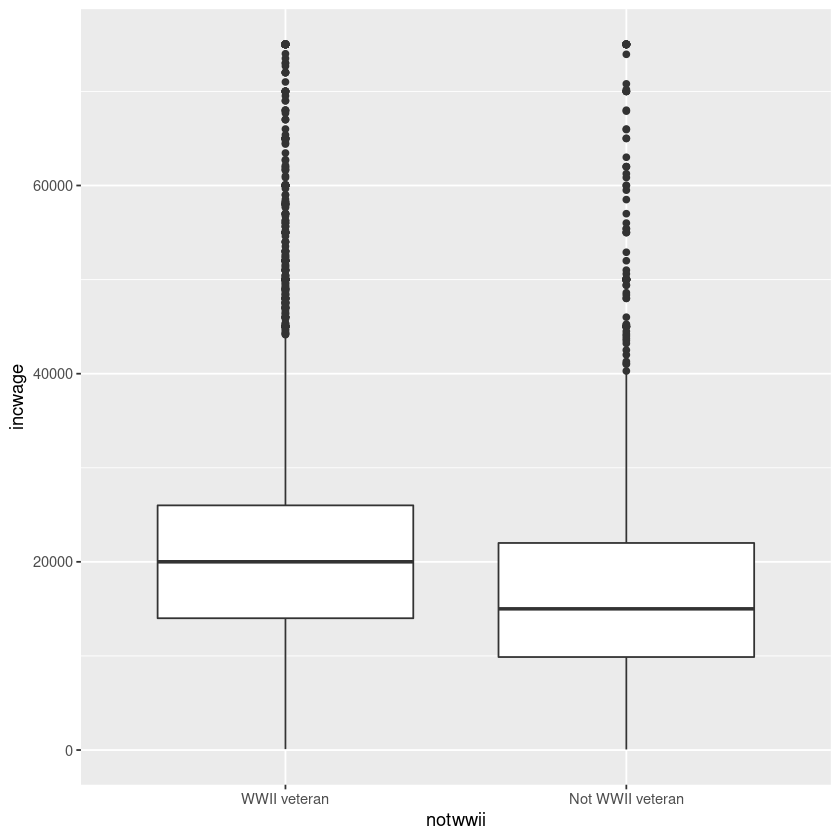

In [9]:
ggplot(subset(data_c80_regsample, birthyr == 1926 & (birthqtr == 3 | birthqtr == 4)), 
              aes(notwwii, incwage)) + geom_boxplot()

<font color="blue">
    <h3>
    Question 5</h3>
    Describe what you see. Who earns more among these men born in Q3 or Q4 of 1926, WWII veterans or nonveterans?</font>

WWII veterans definitely earn more among these men, something like \\$20,000 compared to \\$15,000.

<hr>

As discussed in Chapter 6 of <i>Mastering Metrics</i>, <b>quarter of birth</b> is a pretty interesting variable in applied microeconometrics. See section 6.3, and in particular the passage starting on page 229.

Why might it be interesting here? Let us run a handy regression with indicator variables that I have created in the dataset already: `b25q2` for example is an indicator for having been born in the second quarter (April through June) of 1925. Let us toss in all such indicators except `b25q1`, so that men born in quarter 1 of 1925 are the omitted category, and let us run this informative regression (which will end up being like the "first stage" in the instrumental variables chain):

$$
wwii_i = \alpha + \sum_k \theta_k \ birthqtr_i \times birthyr_i + \epsilon_i
$$

When we estimate this, $\alpha$ is the rate of WWII veteran status among men born in 1925:Q1, and the $\theta$'s tell us the difference in the rate of WWII veteran status for men born in different years and quarters. For example, if $\alpha = 0.75$, then 75% of men born in 1925:Q1 are WWII veterans; and if $\theta_{25q2} = 0.005$, then among the cohort born in 1925:Q2, $\alpha + \theta_{25q2} = 0.75 + 0.005 = 0.755$, and thus = 75.5% are WWII veterans.

<h4>
<font color="blue">Complete the code below and run it.</font>
    </h4>

In [10]:
wwii_reg <- lm(wwii ~         b25q2 + b25q3 + b25q4 +
                      b26q1 + b26q2 + b26q3 + b26q4 +
                      b27q1 + b27q2 + b27q3 + b27q4 +
                      b28q1 + b28q2 + b28q3 + b28q4,
              data = data_c80_regsample)
summary(wwii_reg)


Call:
lm(formula = wwii ~ b25q2 + b25q3 + b25q4 + b26q1 + b26q2 + b26q3 + 
    b26q4 + b27q1 + b27q2 + b27q3 + b27q4 + b28q1 + b28q2 + b28q3 + 
    b28q4, data = data_c80_regsample)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7594 -0.2983  0.2460  0.2565  0.7711 

Coefficients:
             Estimate Std. Error t value             Pr(>|t|)    
(Intercept)  0.746137   0.006344 117.604 < 0.0000000000000002 ***
b25q2        0.005055   0.008949   0.565             0.572191    
b25q3        0.008687   0.008908   0.975             0.329455    
b25q4        0.007843   0.008981   0.873             0.382559    
b26q1        0.013224   0.008991   1.471             0.141382    
b26q2        0.006499   0.008996   0.722             0.470013    
b26q3       -0.002642   0.008805  -0.300             0.764106    
b26q4        0.003811   0.009043   0.421             0.673402    
b27q1       -0.029913   0.008896  -3.363             0.000772 ***
b27q2       -0.050712   0.008896  -5.701        

<font color="blue">
    <h3>
    Question 6</h3>
    Describe what you see. Which group has the highest rate of WWII veteran status? Which group has the lowest rate? Can you see a "cliff" here, which WWII service really falls off of? (No need to look for an extremely precise cliff; cliffs can be comically abrupt or a little more gradual.)</font>

The highest rate of WWII veteran status is in the cohort born in 1926:Q1, among whom in 1980 about $0.746 + 0.013$ or 76% of men were WWII veterans.

There is something of a cliff for the men born in 1928, but precisely where it occurs is less clear. It looks a little more gradual in these data, with reductions of 10-15 percentage points among men born late in 1927, and then reductions of 30-45 percentage points among men born early in 1928, all relative to the rate among the omitted group. Finally we see reductions of about 50 percentage points for those born late in 1928.

<hr>

Now consider this comparison. Let's look at two groups separated by birth year:

1. Men born in Q3 or Q4 of 1926
2. Men born in Q3 or Q4 of 1928

I've coded this using the categorical variable `srgrp`, because it helpfully places the value labels along the bottom of the plot. The labels shown the percentages of these two groups that are veterans of WWII. For the 1926 group and many birth years before, the WWII veteran share is around 75%. For the 1928 group, it is about 25%. 

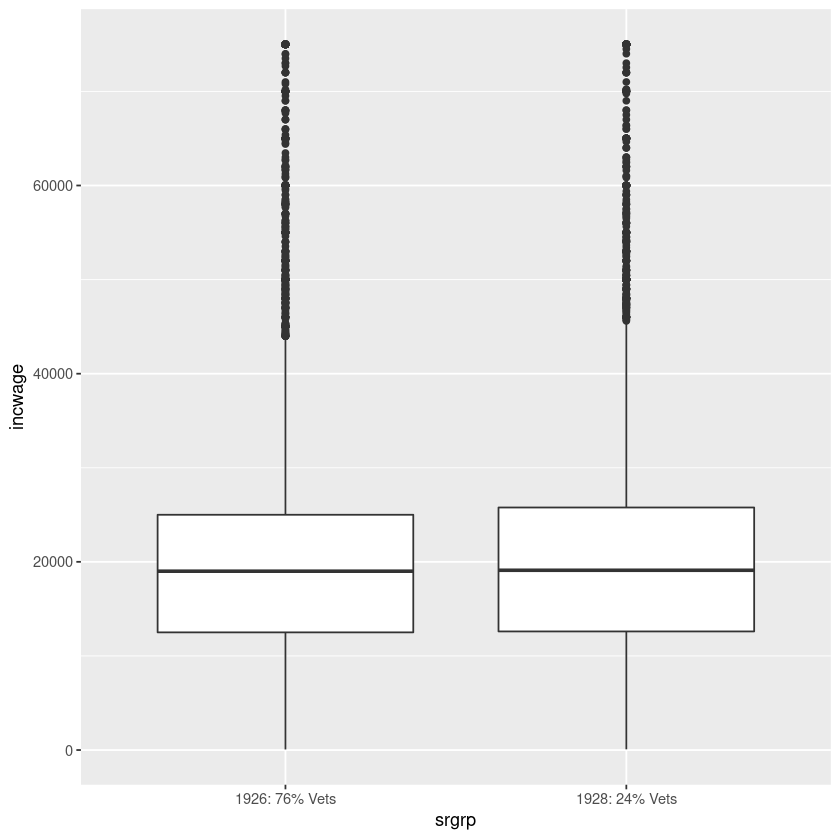

In [11]:
ggplot(subset(data_c80_regsample, srgrp != "NA"), 
       aes(srgrp, incwage)) + geom_boxplot()

<font color="blue">
    <h3>
    Question 7</h3>
Describe what you see. Despite the large difference in the WWII-veteran shares of these birth cohorts, are there large differences in earnings? Is this what you would expect to see if the cohort born later had half as many WWII veterans, and WWII veterans earned a lot more?</font>

There are basically no differences in earnings here! This is not at all what we would expect to see; if WWII veterans earn more, then the group with more veterans should also earn more.

<font color="blue">
    <h3>
    Question 8</h3>
Discuss how the OLS results above, in Questions 1-4, appear incongruous with this second box plot. Feel free to consult the hyperlinked papers above if you are not sure, but please write answers in your own words.</font>

The earlier results we saw, where WWII veterans appear to earn quite a bit more than nonveterans, do not fit with what we see here in the box plots. (There is a good amount of overlap here between questions 7 and 8.) If WWII veterans earn more, then the group that has more WWII veterans should also earn more.

<hr>

Quarter of birth certainly seems important for WWII service in this sample, for obvious reasons. Men could be born too late to serve in WWII, which ended in August 1945. With some exceptions, which we have seen, that meant that men born in Q3 or Q4 of 1928 were generally too young ever to serve in the war. 

We have already run something that looks like a <i>first stage</i> regression. It was:

$$
wwii_i = \alpha + \sum_k \theta_k \ birthqtr_i \times birthyr_i + \epsilon_i
$$

What if we looked at the effect of quarter of birth on earnings in a type of <i>reduced form</i> regression of log earnings on quarter of birth variables? That equation looks like this:

$$
\ln Y_i = \alpha^Y + \sum_k \psi_k \ birthqtr_i \times birthyr_i + \nu_i
$$

<h4>
<font color="blue">Complete the code below and run it.</font>
    </h4>

In [12]:
c80_rf <- lm(logincwage ~ b25q1 + b25q2 + b25q3 +
                          b26q1 + b26q2 + b26q3 + 
                          b27q1 + b27q2 + b27q3 + 
                          b28q1 + b28q2 + b28q3 + 
                          factor(birthyr),
             data = data_c80_regsample)
summary(c80_rf)


Call:
lm(formula = logincwage ~ b25q1 + b25q2 + b25q3 + b26q1 + b26q2 + 
    b26q3 + b27q1 + b27q2 + b27q3 + b28q1 + b28q2 + b28q3 + factor(birthyr), 
    data = data_c80_regsample)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7297 -0.3030  0.1136  0.4176  1.5342 

Coefficients:
                     Estimate Std. Error t value             Pr(>|t|)    
(Intercept)          9.691015   0.010466 925.979 < 0.0000000000000002 ***
b25q1                0.018192   0.014786   1.230             0.218553    
b25q2                0.002387   0.014747   0.162             0.871432    
b25q3                0.012055   0.014679   0.821             0.411506    
b26q1                0.020728   0.014918   1.389             0.164697    
b26q2               -0.012808   0.014925  -0.858             0.390789    
b26q3                0.009553   0.014614   0.654             0.513291    
b27q1               -0.035710   0.014583  -2.449             0.014336 *  
b27q2               -0.049041   0.014583  

<font color="blue">
    <h3>
    Question 9</h3>
This is not very easy to read, because there are so many instrumental variables on the right-hand side here. But what do you see? Are some of these instrumental variables statistically significant? Or are none of them?</font> 

<font color="blue">(Sophisticated users will note two things: [1] the <i>F</i>-stat is 4.867, which is sort of OK, and [2] this is the reduced form only for the model in column (4) in Angrist and Krueger's Table 4.)</font>

The evidence is mixed, but several of these instrumental variables are indeed individually statistically significant. It turns out that the <i>F</i>-statistic assesses whether they are jointly significant, and they are; we can reject the null hypothesis that all are zero.

We would say that there appears to be some hope here for this IV strategy, which continues in Part 2 because we don't want to crash the __R__ kernel.

<hr>

<font color="red"><b>Please complete Problem Set 3 Part 2 also.</b> The reason there are 2 parts is because starting from scratch allows us to run the IV estimation routine without overloading memory and crashing the R kernel.</font>

<hr>

<i>As warfare and killing rage again in Europe in 2022, let's also take a moment to recognize the great human costs and sacrifices associated with armed conflict and open warfare, and the tragedy of nuclear war.</i>

<hr>

<div style="text-align: right"> <span style="font-family:Papyrus; ">And they lived happily ever after. The End.</span></div>